## Import Modules

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras import Sequential, Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import json
from tqdm.keras import TqdmCallback
from datetime import datetime
from keras.layers import Conv2D, BatchNormalization, ReLU, Add, Input, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import mixed_precision
import time
import cv2
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Enable GPU

In [6]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         tf.config.set_visible_devices(gpus[0], 'GPU')
#         print("Using GPU:", gpus[0])
#     except RuntimeError as e:
#         print(e)

## Load the Dataset

In [7]:
# Define image paths
clean_path = "../my_dataset/celeba_64x64_25000/clean"
noisy_path = "../my_dataset/celeba_64x64_25000/noisy"

# Load all image filenames
image_filenames = sorted(os.listdir(clean_path))

# Load images
clean_images = []
noisy_images = []

for fname in image_filenames:
    clean_img = Image.open(os.path.join(clean_path, fname)).convert('RGB')
    noisy_img = Image.open(os.path.join(noisy_path, fname)).convert('RGB')
    
    clean_images.append(np.array(clean_img))
    noisy_images.append(np.array(noisy_img))

# Convert lists to numpy arrays
clean_images = np.array(clean_images)
noisy_images = np.array(noisy_images)

# Split into training and testing sets
x_train_clean, x_test_clean, x_train_noisy, x_test_noisy = train_test_split(
    clean_images, noisy_images, test_size=0.1, random_state=42)

# Normalize pixel values to [0, 1]
x_train_clean = x_train_clean.astype('float32') / 255.
x_test_clean = x_test_clean.astype('float32') / 255.
x_train_noisy = x_train_noisy.astype('float32') / 255.
x_test_noisy = x_test_noisy.astype('float32') / 255.

# Shuffle data while maintaining alignment
perm = np.random.permutation(len(x_train_clean))
x_train_clean = x_train_clean[perm]
x_train_noisy = x_train_noisy[perm]

perm_test = np.random.permutation(len(x_test_clean))
x_test_clean = x_test_clean[perm_test]
x_test_noisy = x_test_noisy[perm_test]


## Exploratory Data Analysis

### Dataset Size

In [8]:
print(f"Number of training images: {x_train_clean.shape[0]}")
print(f"Number of test images: {x_test_clean.shape[0]}")

Number of training images: 22500
Number of test images: 2500


### Distribution and Value Ranges

In [9]:
print("Image shape (train):", x_train_clean[0].shape)
print("Pixel value range (clean):", x_train_clean.min(), "to", x_train_clean.max())
print("Pixel value range (noisy):", x_train_noisy.min(), "to", x_train_noisy.max())

Image shape (train): (64, 64, 3)
Pixel value range (clean): 0.0 to 1.0
Pixel value range (noisy): 0.0 to 1.0


### Pixel Intensity Distributions

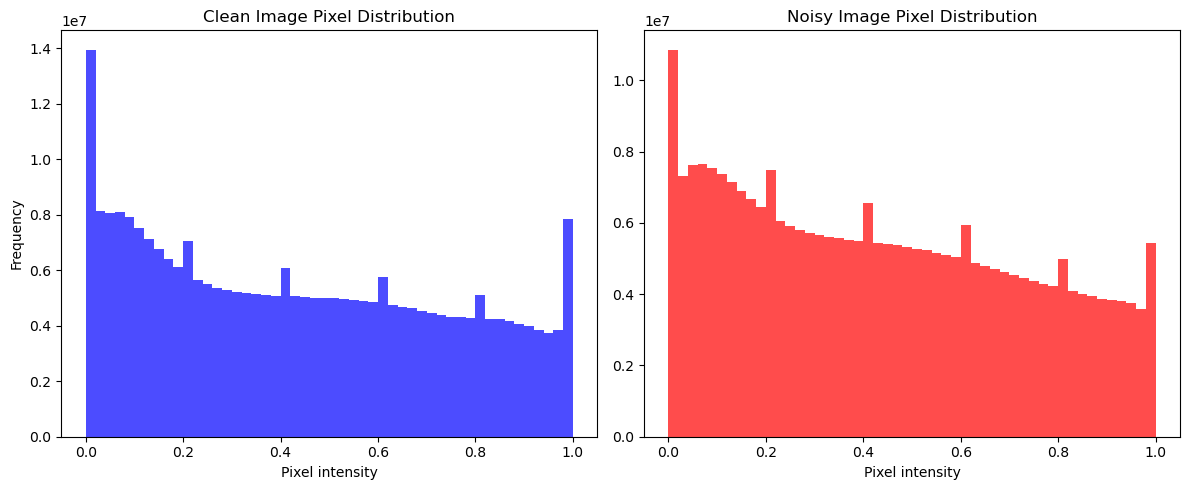

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(x_train_clean.flatten(), bins=50, color='blue', alpha=0.7)
plt.title("Clean Image Pixel Distribution")
plt.xlabel("Pixel intensity")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(x_train_noisy.flatten(), bins=50, color='red', alpha=0.7)
plt.title("Noisy Image Pixel Distribution")
plt.xlabel("Pixel intensity")

plt.tight_layout()
plt.show()

### Visualize Images

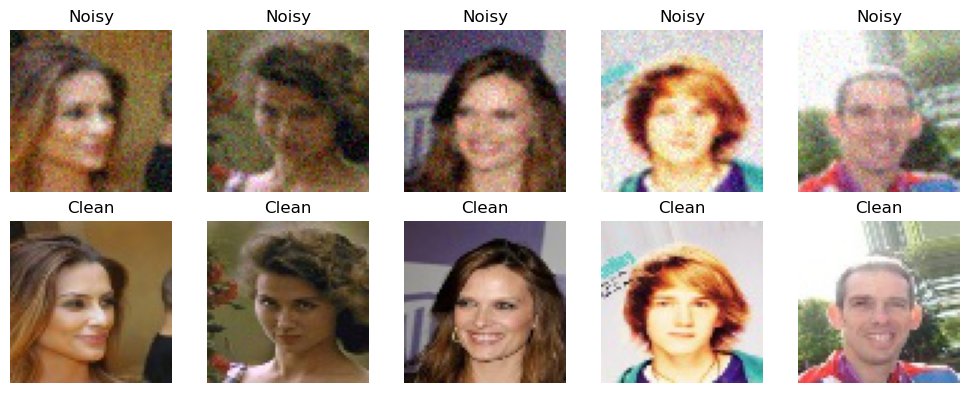

In [11]:
def show_samples(clean, noisy, num_samples=5):
    plt.figure(figsize=(num_samples * 2, 4))
    for i in range(num_samples):
        # Noisy
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(noisy[i])
        plt.title("Noisy")
        plt.axis('off')
        
        # Clean
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(clean[i])
        plt.title("Clean")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_samples(x_train_clean, x_train_noisy)

In [12]:
epochs = 5
batch_size = 16
alpha = 0
loss_function = "vgg_mse"
model_name = f"UDnCNN_{loss_function}_a{alpha}_e{epochs}_b{batch_size}_v2"
print(model_name)

UDnCNN_vgg_mse_a0_e5_b16_v2


## Model Creation

### VGG Loss function

In [13]:
# Select a shallower layer for faster perceptual loss
VGG_LAYER = "block1_conv2"  # Faster and more stable for denoising

# Load VGG model with flexible input size
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(None, None, 3))
vgg.trainable = False

# Create a model that outputs from a chosen VGG layer
vgg_model = Model(inputs=vgg.input, outputs=vgg.get_layer(VGG_LAYER).output)

# Define perceptual loss function
def perceptual_loss_vgg(y_true, y_pred):
    # Scale from [0, 1] to [0, 255] and preprocess
    y_true_vgg = preprocess_input(y_true * 255.0)
    y_pred_vgg = preprocess_input(y_pred * 255.0)

    # Extract VGG features
    features_true = vgg_model(y_true_vgg)
    features_pred = vgg_model(y_pred_vgg)

    # Compute L2 loss on features
    return tf.reduce_mean(tf.square(features_true - features_pred))

# Define combined MSE + VGG perceptual loss
def combined_loss_mse_perceptual(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    perceptual = perceptual_loss_vgg(y_true, y_pred)
    return alpha * mse + (1 - alpha) * perceptual

I0000 00:00:1744563122.582618  403704 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5557 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:09:00.0, compute capability: 8.6


In [14]:
input_img = Input(shape=(x_train_clean.shape[1], x_train_clean.shape[2], x_train_clean.shape[3]))

# Initial Conv + ReLU
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = ReLU()(x)

# Downsampling block 1
x1 = Conv2D(64, (3, 3), padding='same')(x)
x1 = BatchNormalization()(x1)
x1 = ReLU()(x1)
p1 = MaxPooling2D(pool_size=(2, 2))(x1)

# Downsampling block 2
x2 = Conv2D(64, (3, 3), padding='same')(p1)
x2 = BatchNormalization()(x2)
x2 = ReLU()(x2)
p2 = MaxPooling2D(pool_size=(2, 2))(x2)

# Middle block 1
x3 = Conv2D(64, (3, 3), padding='same')(p2)
x3 = BatchNormalization()(x3)
x3 = ReLU()(x3)

# Middle block 2
x4 = Conv2D(64, (3, 3), padding='same')(x3)
x4 = BatchNormalization()(x4)
x4 = ReLU()(x4)

# Upsampling block 1 + skip connection with x2
u1 = UpSampling2D(size=(2, 2))(x4)
u1 = Add()([u1, x2])
u1 = Conv2D(64, (3, 3), padding='same')(u1)
u1 = BatchNormalization()(u1)
u1 = ReLU()(u1)

# Upsampling block 2 + skip connection with x1
u2 = UpSampling2D(size=(2, 2))(u1)
u2 = Add()([u2, x1])
u2 = Conv2D(64, (3, 3), padding='same')(u2)
u2 = BatchNormalization()(u2)
u2 = ReLU()(u2)

# Final output layer
output = Conv2D(3, (3, 3), padding='same')(u2)

# Skip Connection (Residual Learning)
output_img = Add()([input_img, output])

model = Model(inputs=input_img, outputs=output_img)

model.compile(optimizer='adam', loss=combined_loss_mse_perceptual)
# model.summary()

## Train the model

### Callback to Track Time

In [15]:
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()  # returns float in seconds

    def on_train_end(self, logs=None):
        self.total_time = time.time() - self.start_time

time_callback = TimeHistory()

# Custom callback that updates only at the epoch level
class EpochTqdmCallback(TqdmCallback):
    def on_train_batch_end(self, batch, logs=None):
        pass  # Suppress batch updates to keep output clean

### Train

In [16]:
history = model.fit(
    x_train_noisy, x_train_clean,
    validation_data=(x_test_noisy, x_test_clean),
    epochs=epochs,
    batch_size=batch_size,
    verbose=0,  # Hide default Keras output
    callbacks=[time_callback, EpochTqdmCallback(verbose=1)]
)

print("Training time (seconds):", round(time_callback.total_time, 2))

0epoch [00:00, ?epoch/s]2025-04-13 12:52:04.138486: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1105920000 exceeds 10% of free system memory.
2025-04-13 12:52:04.817354: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1105920000 exceeds 10% of free system memory.
2025-04-13 12:52:07.621830: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1105920000 exceeds 10% of free system memory.
2025-04-13 12:52:07.960015: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1105920000 exceeds 10% of free system memory.
  0%|          | 0/5 [00:00<?, ?epoch/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1744563131.516925  404257 service.cc:152] XLA service 0x7fc260003810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744563131.516965  404257 service.cc:160]   StreamExecut

Training time (seconds): 88.84


### Save

In [17]:
model_dir = f"./models/{model_name}"
os.makedirs(model_dir, exist_ok=True)

model.save(os.path.join(model_dir, "model.keras"))
print(f"\n✅ Model saved to: {model_dir}")


✅ Model saved to: ./models/UDnCNN_vgg_mse_a0_e5_b16_v2


## Evaluate the Model

### Predict

In [18]:
predictions = model.predict(x_test_noisy)

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


### Evaluate

In [19]:
mae = np.mean(np.abs(predictions - x_test_clean))
mse = np.mean((predictions - x_test_clean) ** 2)

psnr_total, ssim_total = 0, 0
for i in range(len(x_test_clean)):
    psnr_total += peak_signal_noise_ratio(x_test_clean[i], predictions[i], data_range=1.0)
    ssim_total += structural_similarity(x_test_clean[i], predictions[i], channel_axis=-1, data_range=1.0)

psnr_avg = psnr_total / len(x_test_clean)
ssim_avg = ssim_total / len(x_test_clean)

### Save Metadata

In [20]:
metadata = {
    "model_name": model_name,
    "created_at": datetime.now().isoformat(),
    "loss_function": loss_function,
    "alpha": alpha,
    "epochs": int(epochs),
    "batch_size": int(batch_size),
    "training_time_seconds": round(float(time_callback.total_time), 2),
    "dataset_info": {
        "train_size": int(x_train_clean.shape[0]),
        "test_size": int(x_test_clean.shape[0]),
        "image_shape": list(map(int, x_train_clean.shape[1:]))
    },
    "evaluation_metrics": {
        "mae": round(float(mae), 6),
        "mse": round(float(mse), 6),
        "psnr_avg": round(float(psnr_avg), 3),
        "ssim_avg": round(float(ssim_avg), 3)
    }
}
with open(os.path.join(model_dir, "metadata.json"), "w") as f:
    json.dump(metadata, f, indent=4)

print(f"\n✅ Metadata saved to: {model_dir}")


✅ Metadata saved to: ./models/UDnCNN_vgg_mse_a0_e5_b16_v2


### Visualize the Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.042267196..1.0549725].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.056745753..0.9484708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07301915..1.0009004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05530663..1.0477995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.025031136..1.0414673].


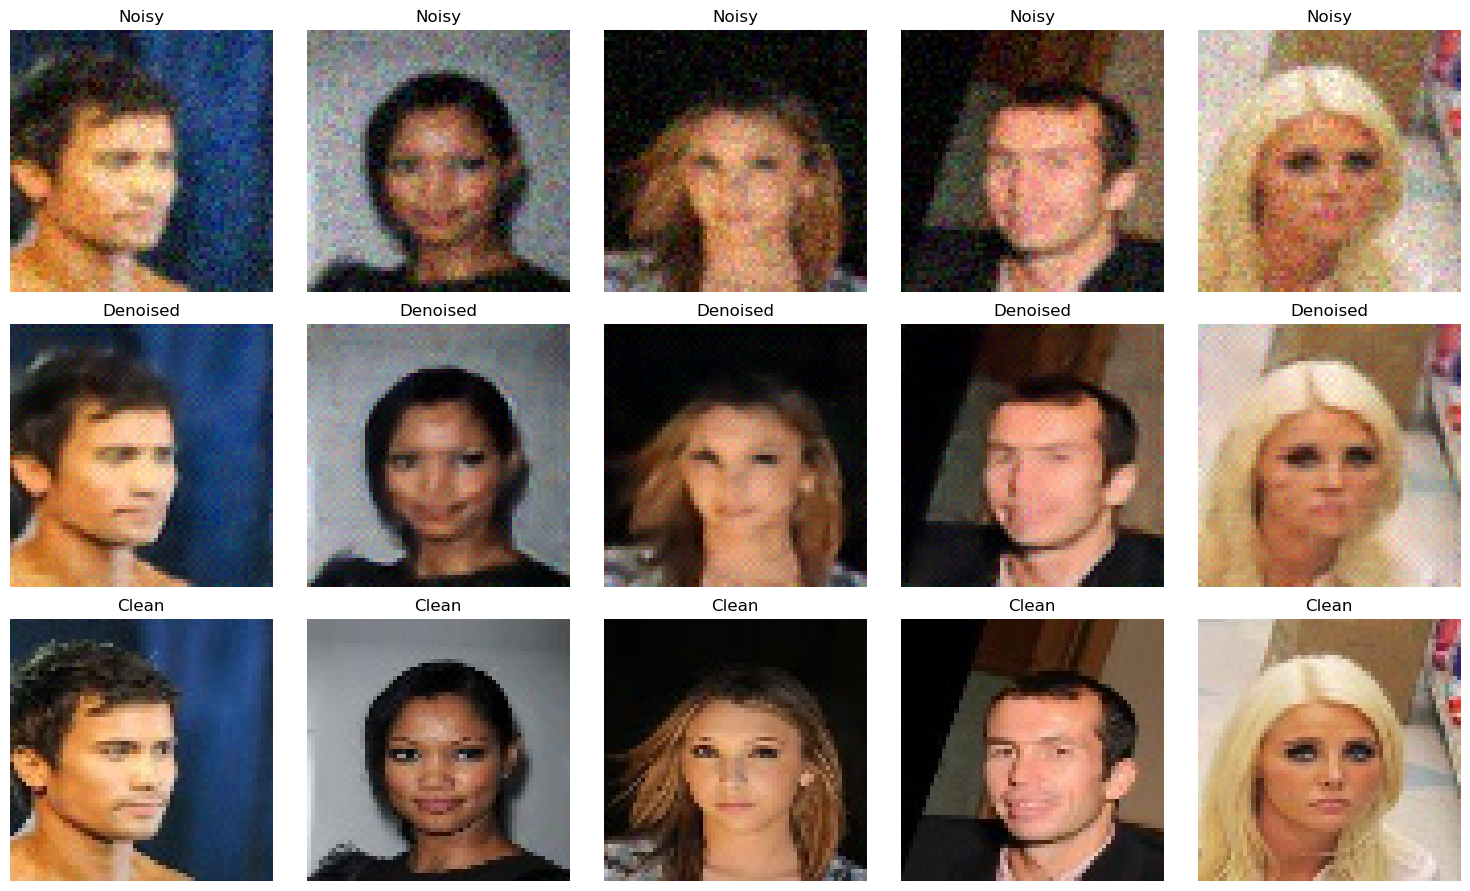

In [21]:
def show_predictions(noisy, clean, predicted, num_images=5):
    plt.figure(figsize=(num_images * 3, 9))
    for i in range(num_images):
        # Noisy
        plt.subplot(3, num_images, i + 1)
        plt.imshow(noisy[i])
        plt.title("Noisy")
        plt.axis('off')

        # Predicted
        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(predicted[i])
        plt.title("Denoised")
        plt.axis('off')

        # Clean
        plt.subplot(3, num_images, i + 1 + num_images * 2)
        plt.imshow(clean[i])
        plt.title("Clean")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_predictions(x_test_noisy, x_test_clean, predictions)

In [22]:
def visualize_and_save_denoising(noisy, predicted, clean, model_dir, num_images=5):
    """
    Visualize and save a comparison of noisy, denoised, and clean images.
    
    Args:
        noisy (numpy array): Noisy input images
        predicted (numpy array): Model predictions (denoised images)
        clean (numpy array): Ground truth clean images
        model_dir (str): Directory where the visualization image will be saved
        num_images (int): Number of image samples to visualize
    """
    plt.figure(figsize=(num_images * 3, 9))

    for i in range(num_images):
        # Noisy input
        plt.subplot(3, num_images, i + 1)
        plt.imshow(noisy[i])
        plt.title("Noisy")
        plt.axis('off')

        # Denoised (model output)
        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(predicted[i])
        plt.title("Denoised")
        plt.axis('off')

        # Ground truth
        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(clean[i])
        plt.title("Clean")
        plt.axis('off')

    plt.tight_layout()
    
    # Save figure
    save_path = os.path.join(model_dir, "denoising_visualization.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()  # Close the figure to free memory

    print(f"📸 Visualization saved to: {save_path}")

visualize_and_save_denoising(
    noisy=x_test_noisy,
    predicted=predictions,
    clean=x_test_clean,
    model_dir=model_dir,
    num_images=5  # You can increase this number if desired
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.042267196..1.0549725].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.056745753..0.9484708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07301915..1.0009004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05530663..1.0477995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.025031136..1.0414673].


📸 Visualization saved to: ./models/UDnCNN_vgg_mse_a0_e5_b16_v2/denoising_visualization.png
